<a href="https://colab.research.google.com/github/AdrianHerczeg/NLP_job_matching/blob/master/Towards_an_end_to_end_system_to_match_resumes_and_job_descriptions(experimental_results)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pdfminer.six

In [3]:
!pip install word2number

In [4]:
!python -m spacy download en_core_web_md

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [5]:
!pip install unidecode

In [6]:
!git clone https://github.com/AdrianHerczeg/NLP_job_matching

fatal: destination path 'NLP_job_matching' already exists and is not an empty directory.


In [0]:
#Extracting text from pdf
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
from io import BytesIO


def pdf_to_text(path):
    """
    Extracts the text from the PDF document located on the path given as the argument,
    and returns the extracted text.

    Attributes
    ----------

    path : str
      the path to the respective document
    """

    manager = PDFResourceManager()
    retstr = BytesIO()
    layout = LAParams(all_texts=True)
    device = TextConverter(manager, retstr, laparams=layout)
    filepath = open(path, 'rb')
    interpreter = PDFPageInterpreter(manager, device)

    for page in PDFPage.get_pages(filepath, check_extractable=True):
        interpreter.process_page(page)

    text = retstr.getvalue()

    filepath.close()
    device.close()
    retstr.close()
    return text.decode('utf-8')

In [0]:
import spacy    #for text preprocessing and entity extraction

#Load the general model for the english language
nlp = spacy.load('en_core_web_md')

In [0]:
#preprocess text 
from unidecode import unidecode
from word2number import w2n



#converting to lower cases
def convert_to_lower(text: str):
    return (str(text)).lower()


#removing accented characters
def remove_accented_chars(text):
    text = unidecode(text)
    return text

#converting numbers to words
def convert_number_to_words(token):
    try:
        x = str(w2n.word_to_num(token))
        return x
    except ValueError:
        return token

#removing extra white spaces
def remove_whitespaces(text):
    text = text.strip()
    return " ".join(text.split())



def preprocess_text(resume):
    resume = convert_to_lower(resume)

    resume = remove_accented_chars(resume)

    resume = remove_whitespaces(resume)

    doc = nlp(resume)

    tokens = []

    for token in doc:                       #tokenization
        add = True                
        text = token.lemma_                 #lemmantization
        if token.pos_ == 'NUM':
            text = convert_number_to_words(text)
            add = True
        if token.pos_ == 'PUNCT':           #eliminating punctuations
            add = False
        if token.is_stop:                   #eliminating stop words
            add = False
        if token.pos_ == 'SYM':             #eliminating special characters
            add = False
        if add:
            tokens.append(text)
            add = True

    parsed_resume = " "

    return parsed_resume.join(tokens)


In [10]:
import pandas as pd     #for data visualization


categories = pd.read_csv('/content/NLP_job_matching/Data/abilities.csv')
categories

,Statistics,Machine Learning,Deep Learning,R Language,Python Language,NLP,Data Engineering
0,statistical models,linear regression,neural network,ggplot,python,nlp,aws
1,statistical modeling,logistic regression,keras,shiny,flask,natural language processing,ec2
2,probability,K means,theano,cran,django,topic modeling,amazon redshift
3,normal distribution,random forest,face detection,dplyr,pandas,lda,s3
4,poisson distribution,xgboost,neural networls,tidyr,numpy,named entity recognition,docker
5,survival models,svm,convolutional neural network(cnn),lubricate,scikitlearn,pos tagging,kubernets
6,hypothesis testing,naive bayes,recurent neural network(RNN),knitr,sklearn,word2vec,scala
7,bayesian inference,pca,object detection,NaN,matplotlib,word embedding,teradata
8,factor analysis,decision tree,yolo,NaN,scipy,lsi,google big query
9,forecasting,svd,gpu,NaN,bokeh,spacy,aws lambda


In [0]:
#skills
from spacy.matcher import PhraseMatcher   #for entity extraction
import numpy as np                        #for mathematical calculations



def is_nan(x):
    return x is np.nan or x != x



def get_skills(resume):
    skills = {}
    doc = nlp(resume)
    for category in categories:
        matched_skills = []
        terms = [term for term in categories[category]
                 if is_nan(term) == False]
        patterns = [nlp.make_doc(text) for text in terms]
        matcher = PhraseMatcher(nlp.vocab, attr="LOWER")
        matcher.add("TerminologyList", None, *patterns)
        matches = matcher(doc)

        for match_id, start, end in matches:
            span = doc[start:end]
            matched_skills.append(str(span))
        skills[category] = matched_skills
    return skills



def in_skills(text, job_description):
    skills = get_skills(job_description)
    preprocessed_text = preprocess_text(text)
    for key in skills.keys():
        if preprocessed_text in skills[key]:
            return True
    return False

In [0]:
#score calculation formula
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


#creating the vectors with the TH-IDF values
def match_resume_job_description(job_description, resume):

    preprocessed_resume = preprocess_text(resume)

    preprocessed_job_description = preprocess_text(job_description)

    corpus = [preprocessed_job_description, preprocessed_resume]

    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(corpus)

    feature_names = vectorizer.get_feature_names()
    dense = X.todense()
    denselist = dense.tolist()

    df = pd.DataFrame(denselist, columns=feature_names,
                      index=['Job Description', 'Resume'])

    selected_skills = pd.DataFrame()

    for category in categories.columns:
        for term in categories[category]:
            if not is_nan(term):
                if in_skills(term, preprocessed_job_description):
                    selected_skills = pd.concat(
                        [selected_skills, df[term]], axis=1)

    return selected_skills


#calculating the score
def calculate_match_score(dataframe_score: type(pd.DataFrame())):
    
    if len(dataframe_score.columns) != 0:
        score = cosine_similarity(dataframe_score[0:1], dataframe_score)
        return score
    return [[0,0]]



def match_and_calculate(job_description, resume):
    matched_frame = match_resume_job_description(job_description, resume)
    return (calculate_match_score(matched_frame))[0][1]




In [13]:
import os               #used to manage the data

path = os.path.join('NLP_job_matching','Data','Matches')
dirs = os.listdir(path)
dirs

['Candidatul_ideal##03-04-2020  18-06-16',
 'Candidatul_ideal##03-04-2020  18-06-16.pdf',
 'Job_Description_3##03-04-2020  18-11-36.pdf',
 'Job_Description_3##03-04-2020  18-11-36',
 'We_are_looking_for_a_Big_Data_Engineer##03-04-2020  18-10-16',
 'We_are_looking_for_a_Big_Data_Engineer##03-04-2020  18-10-16.pdf']

In [0]:
#storing the data in a dictionary for easier access
documents = {}

for dir in dirs:
  if '.pdf' in dir:
 
    job_description_path = os.path.join(path,dir)
    job_description_text = pdf_to_text(job_description_path)
    
    job_description = {}
    job_description['file_name'] = dir
    job_description['text'] = job_description_text


    resumes_folder = job_description_path.split('.pdf')[0]    
    resumes_files = os.listdir(resumes_folder)
 
    set_name = dir.split('.pdf')[0]+"_SET"

    batch = {}
    resumes = []
    for resume_file in resumes_files:
      resume = {}
      resume['file_name'] = resume_file
      resume['text'] = pdf_to_text(os.path.join(resumes_folder,resume_file))
      resumes.append(resume)
    
    batch['job_description'] = job_description
    batch['resumes'] = resumes  

    documents[set_name] = batch  

In [15]:
import json

print(json.dumps(documents,indent = 4))

{
    "Candidatul_ideal##03-04-2020  18-06-16_SET": {
        "job_description": {
            "file_name": "Candidatul_ideal##03-04-2020  18-06-16.pdf",
            "text": "Candidatul ideal \n\nEducation: \n\ncomparable) \n\nKnow-How: \n\n\u2022  Completed studies in a technical discipline (eg. Computer Science, Mathematics, Physics or \n\n \n\n \n\n \n\n \n\n\u2022  Comprehensive knowledge of data structures and algorithms. \n\n\u2022  Understanding of the design and architecture of big data applications and proven experience with \n\nHadoop ecosystems (HDFS, Hive, Impala, YARN, Spark etc) \n\n\u2022  Experience in working with cloud infrastructure (like Cloudera) and workflows for all new and existing \n\ndata sets ingested into data lake \n\n\u2022  Capability to perform complex data transformations by means of efficient, performing and scalable \n\nprogramming in one of the following programming languages: Python / Java / C++/ C# \n\n\u2022  Working experience with databases (SQL

In [16]:
#the TF-IDF measure for one pair resume-job description
random_position = np.random.randint(len(documents["Candidatul_ideal##03-04-2020  18-06-16_SET"]['resumes']))
print(random_position)

j_d = documents["Candidatul_ideal##03-04-2020  18-06-16_SET"]['job_description']['text']
resume_1 = documents["Candidatul_ideal##03-04-2020  18-06-16_SET"]['resumes'][random_position]['text']
match_resume_job_description(j_d,resume_1)

15


,python,docker,hive,hadoop,sql
Job Description,0.051603,0.051603,0.051603,0.051603,0.051603
Resume,0.000000,0.000000,0.000000,0.000000,0.000000


#Dataset and experimets

Our dataset is composed from 220 resumes, the same dataset provided by (https://www.kaggle.com/dataturks/resume-entities-for-ner), we converted the json document provided by the author in 220 pdf resumes. We fist split the 220 resumes across all three job descriptions and measure the requiered time for each matching operation. We then apply the alghoritm to all 220 resumes for each job description.

In [0]:
def apply_matching_alghorim(job_description_text : str, resume_text : str):
  match = match_and_calculate(job_description_text, resume_text)
  return match

In [0]:
from timeit import default_timer as timer

##First job description results

In [114]:
#applying the algohirm for one resume and one job description
random_position = np.random.randint(len(documents["Candidatul_ideal##03-04-2020  18-06-16_SET"]['resumes']))
job_description_sample = documents["Candidatul_ideal##03-04-2020  18-06-16_SET"]['job_description']['text']
job_description_nlp = nlp(job_description_sample)



resume_sample = documents["Candidatul_ideal##03-04-2020  18-06-16_SET"]['resumes'][random_position]['text']
resume_nlp = nlp(resume_sample)

start = timer()
match = match_and_calculate(job_description,resume)
end = timer()

time = end - start

print("Statistics for matching one resume and one job description")
print("""For: 
one job description with {} words 
and one resume with {} words, 
the necesary time for calculating the matching score is {:.2f}""".
format(len(job_description_nlp),
                len(resume_nlp),
                time
        ))



Statistics for matching one resume and one job description
For: 
one job description with 588 words 
and one resume with 1298 words, 
the necesary time for calculating the matching score is 4.28


In [0]:
times_for_matches_job_description_1 = []

In [0]:
times_for_matches_job_description_2 = []

In [0]:
times_for_matches_job_description_3 = []

In [24]:
#applying the alghoritm for all resumes associated with one job description

job_description_sample = documents["Candidatul_ideal##03-04-2020  18-06-16_SET"]['job_description']['text']
job_description_nlp = nlp(job_description_sample)

resumes = {}


for i in range(len(documents["Candidatul_ideal##03-04-2020  18-06-16_SET"]['resumes'])):
  
  resume = documents["Candidatul_ideal##03-04-2020  18-06-16_SET"]['resumes'][i]

  resume_details = {}
  resume_details['resume_text'] = resume['text']

  resume_nlp = nlp(resume['text'])
  resume_details['word_numbers'] = len(resume_nlp)
  
  resumes[resume['file_name']] = resume_details


total_words = 0
for key in resumes.keys():
  total_words = total_words + resumes[key]['word_numbers']


average_words = total_words / (len(documents["Candidatul_ideal##03-04-2020  18-06-16_SET"]['resumes']))
average_words


start = timer()

for key in resumes.keys():
  resume_text = resumes[key]['resume_text']
  score = match_and_calculate(job_description_sample,resume_text)
  resumes[key]['compatibility_score'] = score

end = timer()
total_time = end - start
average_time = total_time / len(resumes.keys())


print(
"""On one job description with {} words and 
{} resume with an average of {} words / resume,
the total necesary time is {} minutes, 
with an average of {} seconds / match calculation""".format(
    len(job_description_nlp),
    len(resumes.keys()),
    average_words,
    total_time/60,
    average_time

))
  

On one job description with 588 words and 
74 resume with an average of 748.7027027027027 words / resume,
the total necesary time is 6.309006745633334 minutes, 
with an average of 5.1154108748378375 seconds / match calculation


In [25]:
job_description_sample = documents["Candidatul_ideal##03-04-2020  18-06-16_SET"]['job_description']['text']
job_description_nlp = nlp(job_description_sample)

total_time = 0




for i in range(len(documents["Candidatul_ideal##03-04-2020  18-06-16_SET"]['resumes'])):
  
  resume = documents["Candidatul_ideal##03-04-2020  18-06-16_SET"]['resumes'][i]
  start = timer()
  score = match_and_calculate(job_description_sample, resume['text'])
  end = timer()
  total_time = total_time + (end - start)
  times_for_matches_job_description_1.append(total_time)

print(times_for_matches_job_description_1)




[5.007534538999948, 10.086090244999923, 15.088684965999846, 20.186675490999846, 25.278267662999838, 30.42927329699978, 35.56155772699981, 40.70459921399981, 45.79022305999979, 50.89658509399976, 55.971863098999734, 61.16084394599977, 66.26273952299982, 71.37671335999983, 76.47665717699977, 81.66169939999975, 86.69030978799981, 91.76715476199968, 96.72209791499961, 101.64661556099952, 106.72061467699962, 111.83663784299972, 116.8679693339999, 121.84813296699997, 126.8449211169999, 131.98185011199996, 137.24993252099978, 142.28531945899965, 147.26298836299964, 152.32643668799972, 157.39413916199976, 162.46666001899973, 167.4675487009996, 172.54769623199957, 177.5799850869995, 182.5517885809994, 187.76143303899937, 192.7865692369993, 197.84223141099926, 202.92663365699912, 207.94743701799905, 212.92077091399904, 218.02656752599898, 223.08326501999898, 228.11328986399883, 233.15273977399886, 238.14329402899887, 244.8851200089988, 250.27149821199862, 255.11891251999862, 260.0690670039986, 2

##Second job description

In [26]:
#applying the alghoritm for all resumes associated with one job description

job_description_sample = documents["Job_Description_3##03-04-2020  18-11-36_SET"]['job_description']['text']
job_description_nlp = nlp(job_description_sample)

resumes = {}


for i in range(len(documents["Job_Description_3##03-04-2020  18-11-36_SET"]['resumes'])):
  
  resume = documents["Job_Description_3##03-04-2020  18-11-36_SET"]['resumes'][i]

  resume_details = {}
  resume_details['resume_text'] = resume['text']

  resume_nlp = nlp(resume['text'])
  resume_details['word_numbers'] = len(resume_nlp)
  
  resumes[resume['file_name']] = resume_details


total_words = 0
for key in resumes.keys():
  total_words = total_words + resumes[key]['word_numbers']


average_words = total_words / (len(documents["Job_Description_3##03-04-2020  18-11-36_SET"]['resumes']))



start = timer()

for key in resumes.keys():
  resume_text = resumes[key]['resume_text']
  score = match_and_calculate(job_description_sample,resume_text)
  resumes[key]['compatibility_score'] = score

end = timer()
total_time = end - start
average_time = total_time / len(resumes.keys())


print(
"""On one job description with {} words and 
{} resume with an average of {} words / resume,
the total necesary time is {} minutes, 
with an average of {} seconds / match calculation""".format(
    len(job_description_nlp),
    len(resumes.keys()),
    average_words,
    total_time/60,
    average_time

))
  

On one job description with 416 words and 
76 resume with an average of 720.4868421052631 words / resume,
the total necesary time is 5.150165196700001 minutes, 
with an average of 4.065919892131579 seconds / match calculation


In [27]:
job_description_sample = documents["Job_Description_3##03-04-2020  18-11-36_SET"]['job_description']['text']
job_description_nlp = nlp(job_description_sample)

total_time = 0




for i in range(len(documents["Job_Description_3##03-04-2020  18-11-36_SET"]['resumes'])):
  resume = documents["Job_Description_3##03-04-2020  18-11-36_SET"]['resumes'][i]
  start = timer()
  score = match_and_calculate(job_description_sample, resume['text'])
  end = timer()
  total_time = total_time + (end - start)
  times_for_matches_job_description_2.append(total_time)

print(times_for_matches_job_description_2)


[4.025398108000218, 8.025734047000242, 12.102731873000266, 16.20401899200033, 20.15372346200047, 24.161618170000565, 28.158125067000583, 32.508781099000544, 36.67173119900053, 40.74897255500059, 45.042097431000684, 49.110212979000835, 53.15532000200096, 57.177277212000945, 61.340625973001124, 65.39566447500101, 69.29466107900089, 73.22329887300089, 77.13508822700078, 81.22348569100086, 85.12745821100089, 89.14116582800102, 93.14981628700116, 97.04331634100117, 100.95044649500119, 104.98108536700124, 108.97547586600126, 112.97959246000119, 116.88295029100118, 120.90016241800117, 124.95289166700127, 128.89383316000112, 132.80864010600112, 136.8453720670011, 140.9359460960011, 145.2859208440011, 149.37862437200124, 153.73850788300115, 157.9497560770012, 163.893652720001, 167.94700538700113, 171.9320789120011, 176.07548559600104, 180.27273890300103, 184.29446214700124, 188.3144129460013, 192.32744051000122, 196.3997771560014, 200.40904701800127, 204.5035860430014, 208.62830506000137, 212.8

##Third job description

In [28]:
#applying the alghoritm for all resumes associated with one job description

job_description_sample = documents["We_are_looking_for_a_Big_Data_Engineer##03-04-2020  18-10-16_SET"]['job_description']['text']
job_description_nlp = nlp(job_description_sample)

resumes = {}


for i in range(len(documents["We_are_looking_for_a_Big_Data_Engineer##03-04-2020  18-10-16_SET"]['resumes'])):
  
  resume = documents["We_are_looking_for_a_Big_Data_Engineer##03-04-2020  18-10-16_SET"]['resumes'][i]

  resume_details = {}
  resume_details['resume_text'] = resume['text']

  resume_nlp = nlp(resume['text'])
  resume_details['word_numbers'] = len(resume_nlp)
  
  resumes[resume['file_name']] = resume_details


total_words = 0
for key in resumes.keys():
  total_words = total_words + resumes[key]['word_numbers']


average_words = total_words / (len(documents["We_are_looking_for_a_Big_Data_Engineer##03-04-2020  18-10-16_SET"]['resumes']))
average_words


start = timer()

for key in resumes.keys():
  resume_text = resumes[key]['resume_text']
  score = match_and_calculate(job_description_sample,resume_text)
  resumes[key]['compatibility_score'] = score

end = timer()
total_time = end - start
average_time = total_time / len(resumes.keys())


print(
"""On one job description with {} words and 
{} resume with an average of {} words / resume,
the total necesary time is {} minutes, 
with an average of {} seconds / match calculation""".format(
    len(job_description_nlp),
    len(resumes.keys()),
    average_words,
    total_time/60,
    average_time

))
  

On one job description with 416 words and 
70 resume with an average of 701.7 words / resume,
the total necesary time is 4.483754584733333 minutes, 
with an average of 3.843218215485714 seconds / match calculation


In [29]:
job_description_sample = documents["We_are_looking_for_a_Big_Data_Engineer##03-04-2020  18-10-16_SET"]['job_description']['text']
job_description_nlp = nlp(job_description_sample)

total_time = 0




for i in range(len(documents["We_are_looking_for_a_Big_Data_Engineer##03-04-2020  18-10-16_SET"]['resumes'])):
  resume = documents["We_are_looking_for_a_Big_Data_Engineer##03-04-2020  18-10-16_SET"]['resumes'][i]
  start = timer()
  score = match_and_calculate(job_description_sample, resume['text'])
  end = timer()
  total_time = total_time + (end - start)
  times_for_matches_job_description_3.append(total_time)

print(times_for_matches_job_description_3)


[3.7524439129997518, 7.528132099999766, 11.399795389999326, 15.18552417399951, 19.000787392999428, 22.869993486999647, 26.93200410199961, 30.997230086999934, 34.93787661899978, 38.76326230399991, 42.73627173199975, 46.56369229499978, 50.37979781999957, 54.272920035999505, 58.09729540399985, 61.99369129199977, 65.90532931599955, 69.88073200199915, 73.7870975199994, 77.64867370199954, 81.42804230699949, 85.13895911499912, 89.00243360899913, 92.83640935499898, 96.57842633299879, 100.3426553739987, 104.18222896699854, 107.95639225299874, 111.74653529899842, 115.49359499599859, 119.1685273729986, 122.8605164849987, 126.6185091939983, 130.5559189799983, 134.29398459499816, 138.05963432199815, 141.92829458899814, 145.69026591499824, 149.3870539279983, 153.16010991099847, 156.91052830099852, 160.65754661799838, 164.4570688549984, 168.16330820299845, 171.96499857199842, 176.00827949999848, 179.70904131899852, 183.85290975599855, 189.37694567199878, 193.20989901799885, 196.88553217099889, 200.59

In [30]:
print(times_for_matches_job_description_1)
print(times_for_matches_job_description_2)
print(times_for_matches_job_description_3)

[5.007534538999948, 10.086090244999923, 15.088684965999846, 20.186675490999846, 25.278267662999838, 30.42927329699978, 35.56155772699981, 40.70459921399981, 45.79022305999979, 50.89658509399976, 55.971863098999734, 61.16084394599977, 66.26273952299982, 71.37671335999983, 76.47665717699977, 81.66169939999975, 86.69030978799981, 91.76715476199968, 96.72209791499961, 101.64661556099952, 106.72061467699962, 111.83663784299972, 116.8679693339999, 121.84813296699997, 126.8449211169999, 131.98185011199996, 137.24993252099978, 142.28531945899965, 147.26298836299964, 152.32643668799972, 157.39413916199976, 162.46666001899973, 167.4675487009996, 172.54769623199957, 177.5799850869995, 182.5517885809994, 187.76143303899937, 192.7865692369993, 197.84223141099926, 202.92663365699912, 207.94743701799905, 212.92077091399904, 218.02656752599898, 223.08326501999898, 228.11328986399883, 233.15273977399886, 238.14329402899887, 244.8851200089988, 250.27149821199862, 255.11891251999862, 260.0690670039986, 2

In [0]:
import matplotlib.pyplot as plt


##Charts

In [0]:
number_of_resumes_1 = [i+1 for i in range(len(times_for_matches_job_description_1))]
number_of_resumes_2 = [i+1 for i in range(len(times_for_matches_job_description_2))]
number_of_resumes_3 = [i+1 for i in range(len(times_for_matches_job_description_3))]



<BarContainer object of 74 artists>

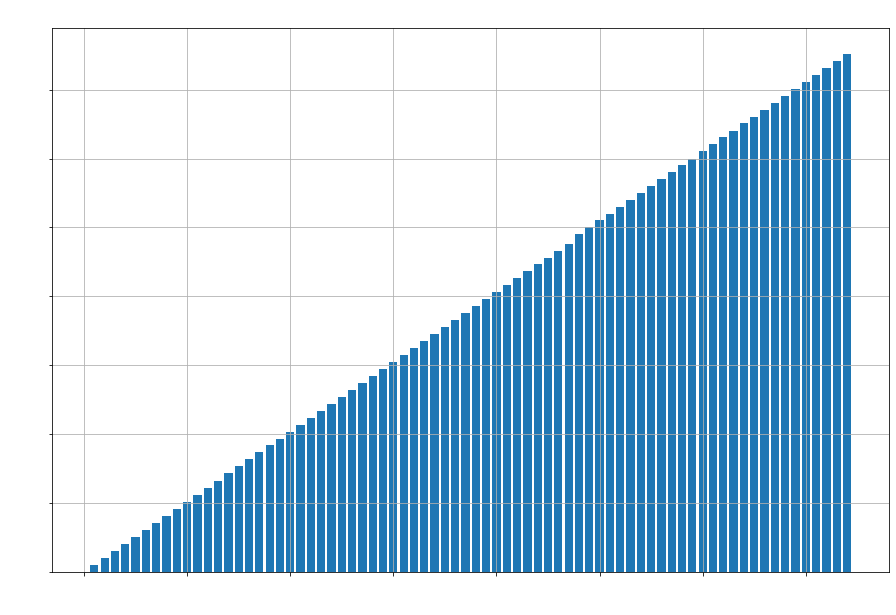

In [33]:
plt.figure(figsize = (15, 10))
plt.xlabel("Number of resumes", fontdict={'size' : 15, 'color':'white'})
plt.ylabel("Time to process", fontdict = {'size' : 15, 'color':'white'})
plt.title("Time complexity for the first job description", 
          fontdict = {'size': 20,
                      'color':'white'})
plt.grid("True")
plt.xticks(color = 'white')
plt.yticks(color = 'white')

plt.bar(number_of_resumes_1,times_for_matches_job_description_1)


<BarContainer object of 76 artists>

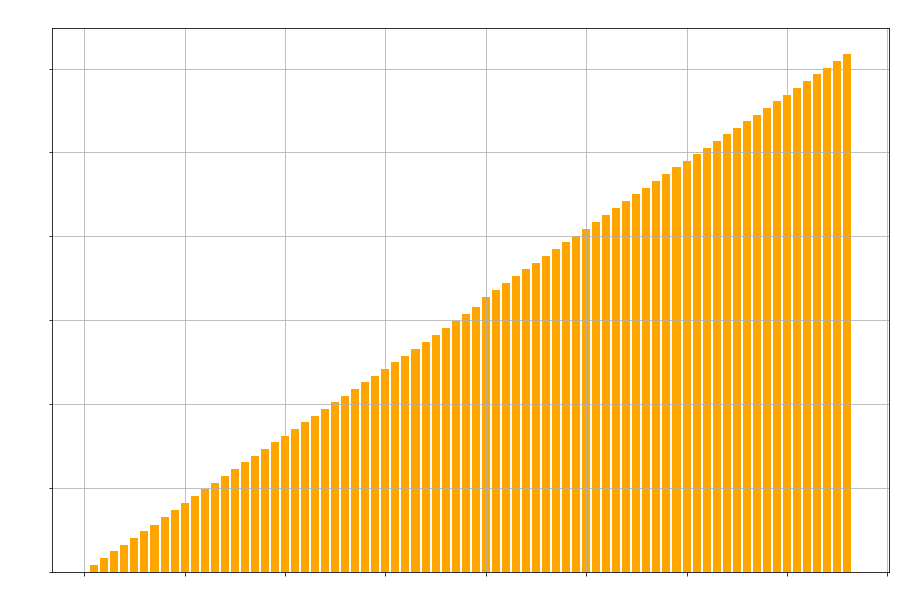

In [34]:
plt.figure(figsize = (15, 10))
plt.xlabel("Number of resumes", fontdict={'size' : 15, 'color':'white'})
plt.ylabel("Time to process", fontdict = {'size' : 15, 'color':'white'})
plt.title("Time complexity for the second job description", 
          fontdict = {'size': 20,
                      'color':'white'})
plt.grid("True")
plt.xticks(color = 'white')
plt.yticks(color = 'white')

plt.bar(number_of_resumes_2,times_for_matches_job_description_2, color = 'orange')


<BarContainer object of 70 artists>

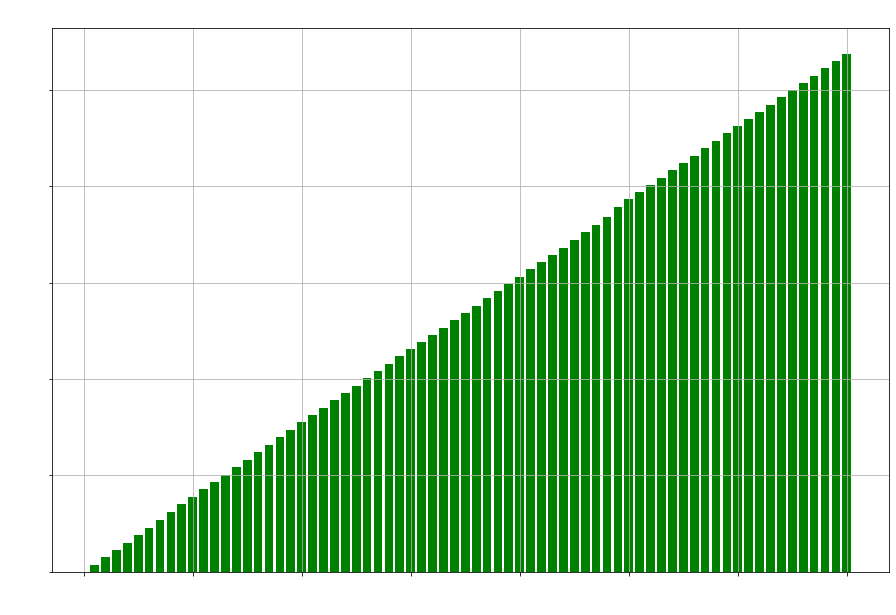

In [35]:
plt.figure(figsize = (15, 10))
plt.xlabel("Number of resumes", fontdict={'size' : 15, 'color':'white'})
plt.ylabel("Time to process", fontdict = {'size' : 15, 'color':'white'})
plt.title("Time complexity for the third job description", 
          fontdict = {'size': 20,
                      'color':'white'})
plt.grid("True")
plt.xticks(color = 'white')
plt.yticks(color = 'white')

plt.bar(number_of_resumes_3,times_for_matches_job_description_3,color = 'green')


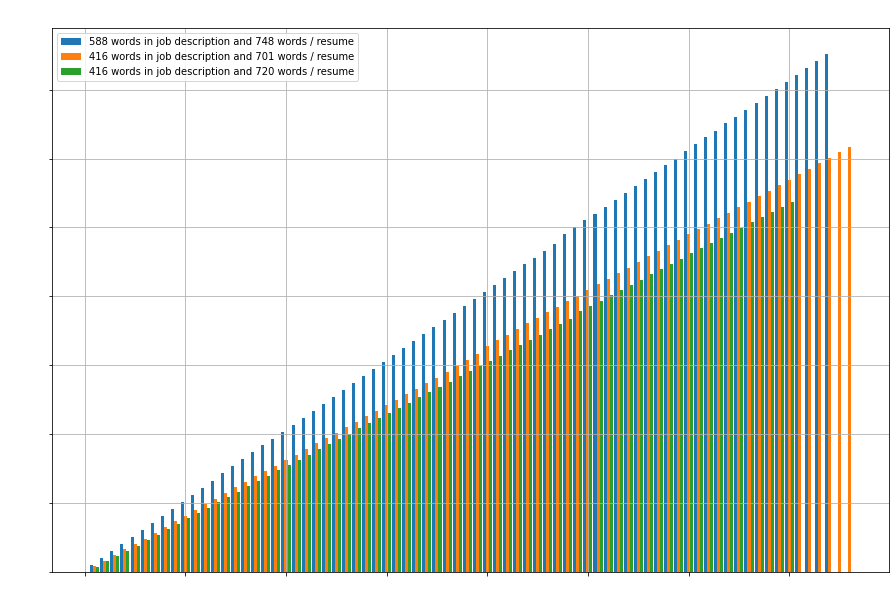

In [38]:
plt.figure(figsize = (15, 10))
plt.xlabel("Number of resumes", fontdict={'size' : 15, 'color':'white'})
plt.ylabel("Required time", fontdict = {'size' : 15, 'color':'white'})
plt.title("Comparison between time compexities", 
          fontdict = {'size': 20,
                      'color':'white'})
plt.grid("True")

w = 0.3


plt.bar(np.array(number_of_resumes_1)-w,
        times_for_matches_job_description_1,
        width = w,
        label = '588 words in job description and 748 words / resume')


plt.bar(np.array(number_of_resumes_2),
        times_for_matches_job_description_2 ,
        width = w,
        label = '416 words in job description and 701 words / resume')


plt.bar(np.array(number_of_resumes_3)+w,
        times_for_matches_job_description_3,
        width = w,
        label = '416 words in job description and 720 words / resume')

plt.xticks(color = 'white')
plt.yticks(color = 'white')

plt.legend()


In [39]:
job_descriptions_words = [588,416,416,588,416,416,588,416,416,588,416,416,588,416,416]
words_resume =           [748,701,720,748,701,720,748,701,720,748,701,720,748,701,720]
res_number =             [1,1,1,5,5,5,10,10,10,25,25,25,50,55,50]
indexes =                [1,5,10,25,50]
res_times = []
for i in indexes:
  res_times.append(times_for_matches_job_description_1[i-1])
  res_times.append(times_for_matches_job_description_2[i-1])
  res_times.append(times_for_matches_job_description_3[i-1])




d = {'Words in job description':job_descriptions_words,
     'Average words / resume':words_resume,
     'Number of resumes':res_number,
      'Total time(seconds)':res_times}
data_table = pd.DataFrame(d)
data_table

,Words in job description,Average words / resume,Number of resumes,Total time(seconds)
0,588,748,1,5.007535
1,416,701,1,4.025398
2,416,720,1,3.752444
3,588,748,5,25.278268
4,416,701,5,20.153723
5,416,720,5,19.000787
6,588,748,10,50.896585
7,416,701,10,40.748973
8,416,720,10,38.763262
9,588,748,25,126.844921


##Data results for the entire dataset

In this section we present the results for the entire 220 resumes dataset paired with every job description.

In [50]:
all_resumes = []

for j_d in documents.keys():
  resumes = documents[j_d]['resumes']
  for resume in resumes:
    all_resumes.append(resume['text'])
len(all_resumes)

220

In [0]:
total_resumes_times_job_description_1 = []
total_resumes_times_job_description_2 = []
total_resumes_times_job_description_3 = []

job_description_1 = documents["Candidatul_ideal##03-04-2020  18-06-16_SET"]['job_description']['text']
job_description_2 = documents["Job_Description_3##03-04-2020  18-11-36_SET"]['job_description']['text']
job_description_3 = documents["We_are_looking_for_a_Big_Data_Engineer##03-04-2020  18-10-16_SET"]['job_description']['text']



for resume in all_resumes:
  start = timer()
  score = match_and_calculate(job_description_1,resume) 
  end = timer()
  total_resumes_times_job_description_1.append(end-start)

  start = timer()
  score = match_and_calculate(job_description_2,resume) 
  end = timer()
  total_resumes_times_job_description_2.append(end-start)

  start = timer()
  score = match_and_calculate(job_description_3,resume) 
  end = timer()
  total_resumes_times_job_description_3.append(end-start)



In [0]:
total_resumes = [i+1 for i in range(len(total_resumes_times_job_description_1))]

In [122]:
aux_1 = total_resumes_times_job_description_1.copy()

for i in range(len(total_resumes_times_job_description_1)-1,0,-1):
  total = 0
  for j in range(i+1):
    total  = total +  total_resumes_times_job_description_1[j]
  aux_1[i] = total

len(aux_1)

220

In [123]:
aux_2 = total_resumes_times_job_description_2.copy()

for i in range(len(total_resumes_times_job_description_2)-1,0,-1):
  total = 0
  for j in range(i+1):
    total  = total +  total_resumes_times_job_description_2[j]
  aux_2[i] = total

len(aux_2)

220

In [124]:
aux_3 = total_resumes_times_job_description_3.copy()

for i in range(len(total_resumes_times_job_description_3)-1,0,-1):
  total = 0
  for j in range(i+1):
    total  = total +  total_resumes_times_job_description_3[j]
  aux_3[i] = total

len(aux_3)

220

##Charts for the entire dataset

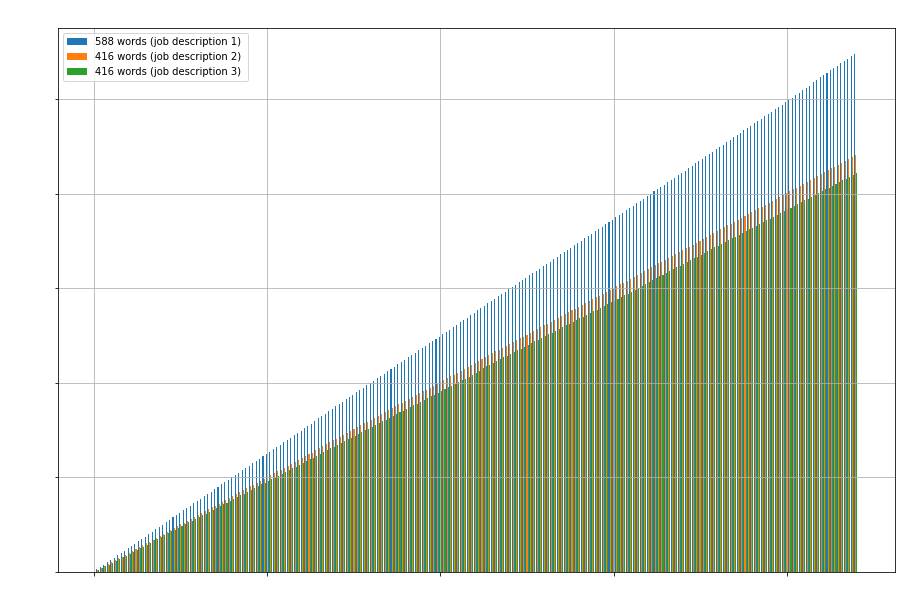

In [125]:


plt.figure(figsize = (15, 10))
plt.xlabel("Number of resumes", fontdict={'size' : 15, 'color':'white'})
plt.ylabel("Required time", fontdict = {'size' : 15, 'color':'white'})
plt.title("Comparison between time compexities", 
          fontdict = {'size': 20,
                      'color':'white'})
plt.grid("True")

w = 0.3


plt.bar(np.array(total_resumes)-w,
        aux_1,
        width = w,
        label = '588 words (job description 1) ')


plt.bar(np.array(total_resumes),
        aux_2 ,
        width = w,
        label = '416 words (job description 2)')


plt.bar(np.array(total_resumes)+w,
        aux_3,
        width = w,
        label = '416 words (job description 3)')

plt.xticks(color = 'white')
plt.yticks(color = 'white')

plt.legend()

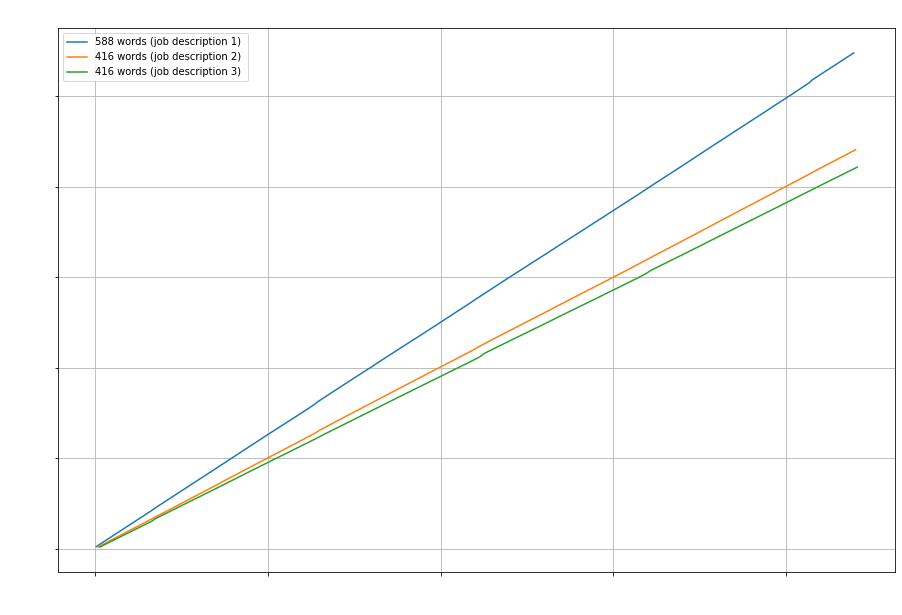

In [126]:


plt.figure(figsize = (15, 10))
plt.xlabel("Number of resumes", fontdict={'size' : 15, 'color':'white'})
plt.ylabel("Required time(seconds)", fontdict = {'size' : 15, 'color':'white'})
plt.title("Comparison between time compexities", 
          fontdict = {'size': 20,
                      'color':'white'})
plt.grid("True")

w = 0.5


plt.plot(np.array(total_resumes)-w,
        aux_1,
    
        label = '588 words (job description 1) ')


plt.plot(np.array(total_resumes),
        aux_2 ,
   
        label = '416 words (job description 2)')


plt.plot(np.array(total_resumes)+w,
        aux_3,
  
        label = '416 words (job description 3)')

plt.xticks(color = 'white')
plt.yticks(color = 'white')

plt.legend()

In [127]:
average_time_first_job_description = aux_1[len(aux_1)-1] / len(aux_1)
average_time_second_job_description = aux_2[len(aux_2)-1] / len(aux_2)
average_time_third_job_description = aux_3[len(aux_3)-1] / len(aux_3)




print("""
The results for constructing the ranking with all 220 resumes are as follows:
for the first job description with {} words the average time / resume was {:.2f} seconds and the total time requiered was {:.2f} minutes,
for the second job description with {} words the average time / resume was {:.2f} seconds and the total time requiered was {:.2f} minutes,
for the third job description with {} words the average time / resume was {:.2f} seconds and the total time requiered was {:.2f} minutes
    """.format(
        len(nlp(job_description_1)),
            average_time_first_job_description,
            aux_1[len(aux_1)-1] / 60,

          len(nlp(job_description_2)),
          average_time_second_job_description,
          aux_2[len(aux_2)-1] / 60,
         
         len(nlp(job_description_3)), 
         average_time_third_job_description,
         aux_3[len(aux_3)-1] / 60
         ))


The results for constructing the ranking with all 220 resumes are as follows:
for the first job description with 588 words the average time / resume was 4.98 seconds and the total time requiered was 18.27 minutes,
for the second job description with 416 words the average time / resume was 4.01 seconds and the total time requiered was 14.70 minutes,
for the third job description with 416 words the average time / resume was 3.83 seconds and the total time requiered was 14.06 minutes
    


From the above prezented data, we can concolude that the total required time scales up exponentialy with the number of words in the job description and liniarly with the number of resumes added. From our experiments, we found that the total time varies based not only on the number of words from the job description but also from the structure of it, the number of words from the resume being less relevant. 